In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [180]:
from bayesfilt import KalmanFilter, UnscentedKalmanFilter, ExtendedKalmanFilter
from bayesfilt import ConstantVelocityND, LinearObservationModel
from bayesfilt import CTRV, CTRA

## Observations

In [181]:
output_dir = os.path.join(os.path.curdir, 'output')
tobs = np.load(os.path.join(output_dir, 'tobs.npy'))
ttrue = np.load(os.path.join(output_dir, 'ttrue.npy'))
yobs = np.load(os.path.join(output_dir, 'yobs.npy'))
ytrue = np.load(os.path.join(output_dir, 'ytrue.npy'))
# ytrue = ytrue[:,:300]
# yobs = yobs[:,:300]
# t = t[:300]

In [182]:
mm = CTRA()
dt = 0.02
start_x = [yobs[0,0], yobs[1,0], yobs[2,0], yobs[3,0], 0.0, 0.0]
start_P = np.diag([0.05, 0.05, 0.05, 0.05, 0.01, 0.01])
truth = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5} # truth-state pairs

In [190]:
kf = KalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)

In [191]:
kf.history

,time_elapsed,observation,truth,observation_cov,filter_mean,filter_cov,filter_nees,filter_nis,filter_loglik,smoother_mean,smoother_cov,smoother_nees,smoother_nis,smoother_loglik


In [193]:
kf.history.

Index(['time_elapsed', 'observation', 'truth', 'observation_cov',
       'filter_mean', 'filter_cov', 'filter_nees', 'filter_nis',
       'filter_loglik', 'smoother_mean', 'smoother_cov', 'smoother_nees',
       'smoother_nis', 'smoother_loglik'],
      dtype='object')

## EKF-CTRA-1

In [183]:
observed = {0:0, 1:1} # observation-state pairs
om = LinearObservationModel(nx=mm.nx, observed=observed)
om.update(sigmas=[0.05]*2)
mm.update(dt = dt, sigmas = [1.0]*2)
ekf = ExtendedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
ekf.f = mm.f
ekf.compute_F = mm.compute_F
ekf.compute_G = mm.compute_G
ekf.compute_Q = mm.compute_Q
ekf.h = om.h
ekf.compute_H = om.compute_H
ekf.compute_J = om.compute_J
ekf.R = om.R.copy()
ekf.initiate_state(tobs[0], start_x.copy(), start_P.copy())
ekf.filter(tobs[1:], [ix for ix in yobs[[0,1],1:].T])
ekf.labels = mm.labels
ekf.smoother()
print(ekf.metrics)
print(ekf.metrics_smoother)

TypeError: 'numpy.ndarray' object is not callable

## EKF-CTRA-2

In [168]:
observed = {0:0, 1:1, 2:2, 3:3} # observation-state pairs
om = LinearObservationModel(nx=mm.nx, observed=observed)
om.update(sigmas=[0.05]*4)
mm.update(dt = dt, sigmas = [1.0]*2)
ekf2 = ExtendedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt)
ekf2.f = mm.f
ekf2.compute_F = mm.compute_F
ekf2.compute_G = mm.compute_G
ekf2.compute_Q = mm.compute_Q
ekf2.h = om.h
ekf2.compute_H = om.compute_H
ekf2.compute_J = om.compute_J
ekf2.R = om.R.copy()
ekf2.initiate_state(tobs[0], start_x, start_P)
ekf2.filter(tobs[1:], [ix for ix in yobs[[0,1,2,3],1:].T])
ekf2.labels = mm.labels
ekf2.smoother()
print(ekf2.metrics)
print(ekf.metrics_smoother)

{'nis': 1258.773, 'nees': 517.562, 'loglik': 1675.692}
{'nis': 56872.402, 'nees': 3159.068, 'loglik': -27210.345}


## UKF-CTRA-1

In [169]:
observed = {0:0, 1:1} # observation-state pairs
om = LinearObservationModel(nx=mm.nx, observed=observed)
om.update(sigmas=[0.05]*2)
mm.update(dt = dt, sigmas = [1.0]*2)
ukf = UnscentedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt, alpha=0.001)
ukf.f = mm.f
ukf.Q = mm.compute_Q()
ukf.subtract_func = mm.subtract
ukf.h = om.h
ukf.R = om.R.copy()
ukf.initiate_state(tobs[0], start_x, start_P)
ukf.filter(tobs[1:], [ix for ix in yobs[[0,1],1:].T])
ukf.labels = mm.labels
ukf.smoother()
print(ukf.metrics)
print(ukf.metrics_smoother)

{'nis': 811.786, 'nees': 419.221, 'loglik': 709.697}
{'nis': 675.153, 'nees': 43.671, 'loglik': 887.045}


## UKF-CTRA-2

In [170]:
observed = {0:0, 1:1, 2:2, 3:3} # observation-state pairs
mm.update(dt = dt, sigmas = [1.0]*2)
om = LinearObservationModel(nx=mm.nx, observed=observed)
om.update(sigmas=[0.05]*4)
ukf2 = UnscentedKalmanFilter(nx=mm.nx, ny = om.ny, dt = dt, alpha=0.001)
ukf2.f = mm.f
ukf2.Q = mm.compute_Q()
ukf2.subtract_func = mm.subtract
ukf2.h = om.h
ukf2.R = om.R.copy()
ukf2.initiate_state(tobs[0], start_x, start_P)
ukf2.filter(tobs[1:], [ix for ix in yobs[[0,1,2,3],1:].T])
ukf2.labels = mm.labels
ukf2.smoother()
print(ukf2.metrics)
print(ukf2.metrics_smoother)

{'nis': 1253.02, 'nees': 521.728, 'loglik': 1676.681}
{'nis': 1066.403, 'nees': 66.455, 'loglik': 1918.662}


## Compare

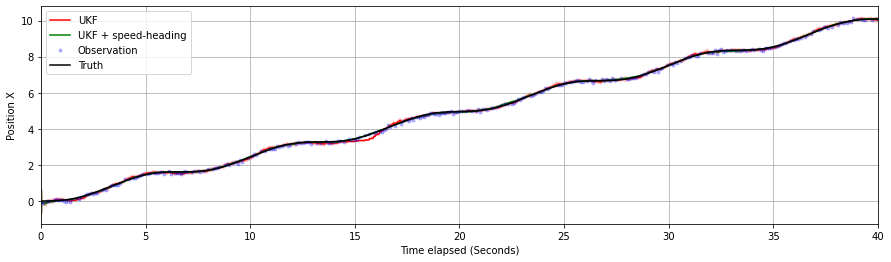

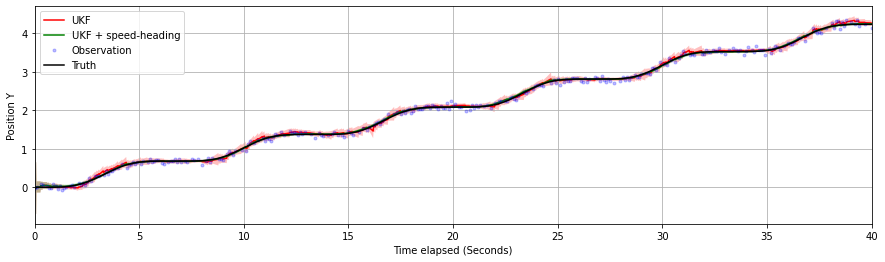

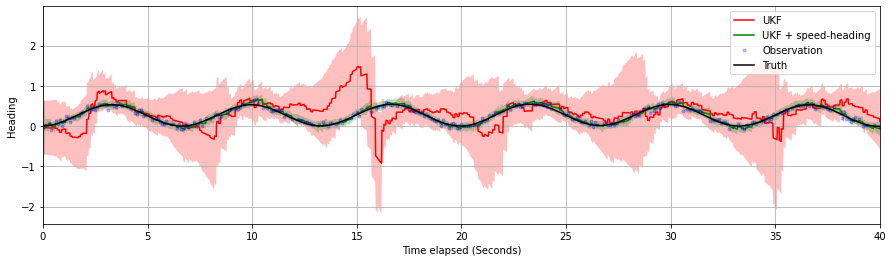

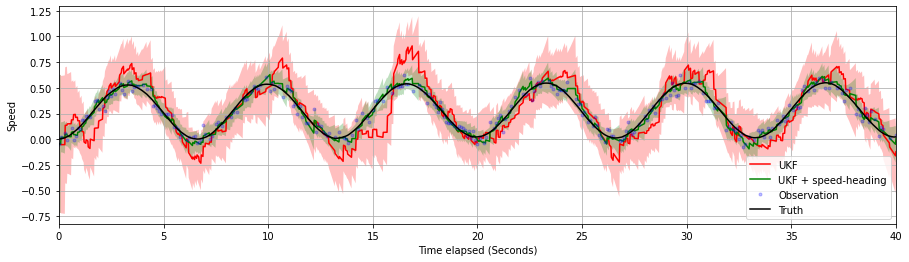

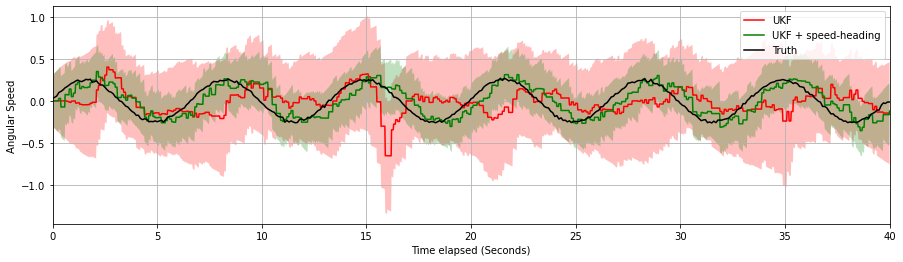

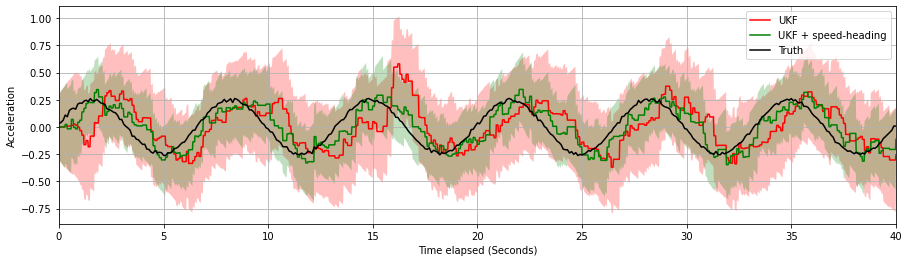

In [174]:
for i in range(mm.nx):
    fig, ax = plt.subplots(figsize=(15,4))
    #ekf.plot_state(ax, i, 'r', 'filter', linestyle='-', label='Filtered')
    ukf.plot_state(ax, i, 'r', 'filter', linestyle='-', label='UKF')
    ukf2.plot_state(ax, i, 'g', 'filter', linestyle='-', label='UKF + speed-heading')
    #ekf2.plot_state(ax, i, 'c', 'smoother', linestyle='-', label='EKS')
    #ukf.plot_state(ax, i, 'g', 'filter', linestyle='-', label='UKF')
    for k, v in observed.items():
        if v == i:
            ax.plot(tobs, yobs[k,:], '.b', label='Observation', alpha=0.25)
    for k, v in truth.items():
        if v == i:
            ax.plot(ttrue, ytrue[k,:], '-k', label='Truth')
    #ekf.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='Smoother')
    #ax.set_xlim([20,40])
    ax.legend()
    ax.grid(True)

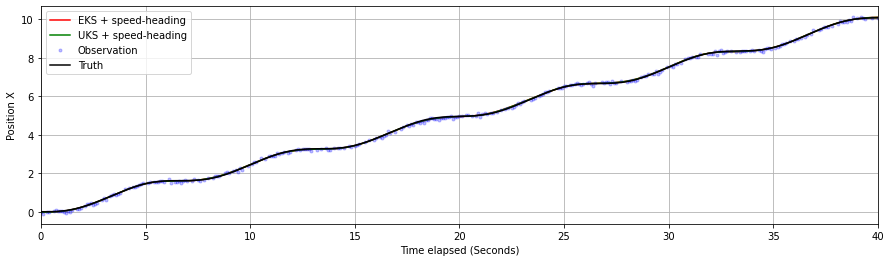

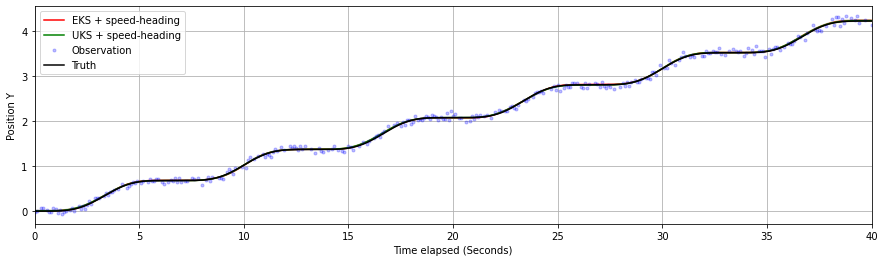

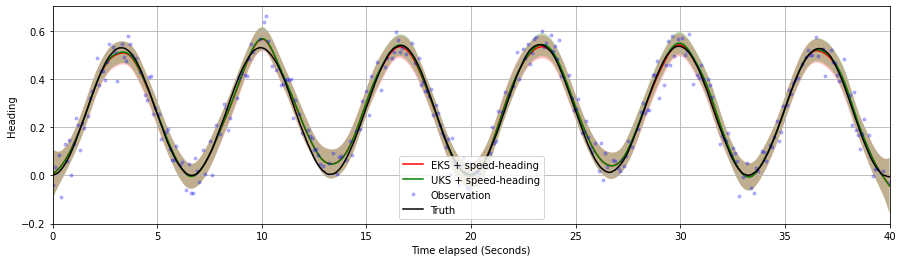

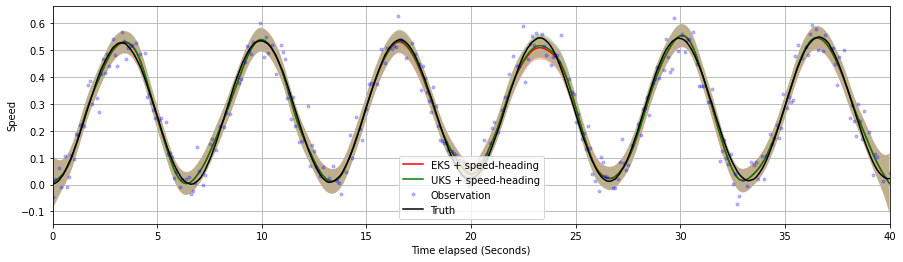

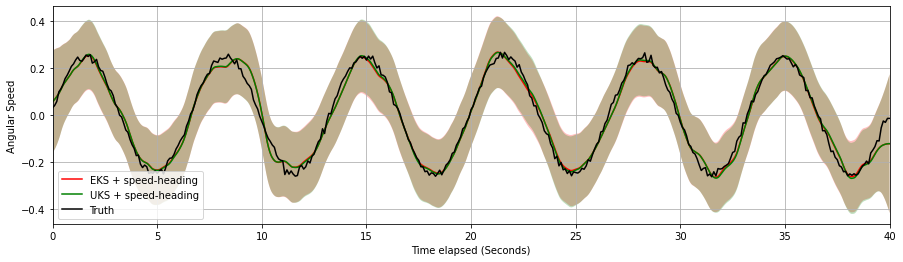

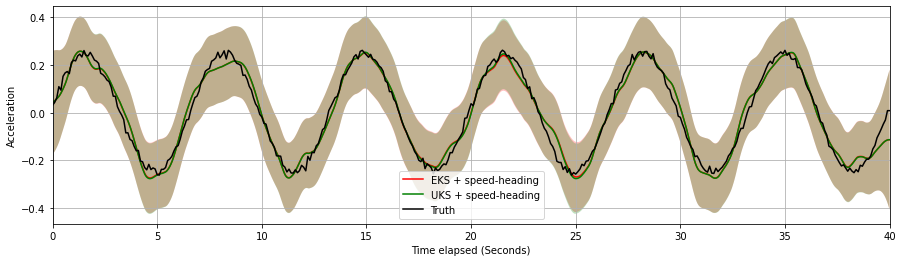

In [175]:
for i in range(mm.nx):
    fig, ax = plt.subplots(figsize=(15,4))
    #ekf.plot_state(ax, i, 'r', 'filter', linestyle='-', label='Filtered')
    ekf2.plot_state(ax, i, 'r', 'smoother', linestyle='-', label='EKS + speed-heading')
    ukf2.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='UKS + speed-heading')
    #ekf2.plot_state(ax, i, 'c', 'smoother', linestyle='-', label='EKS')
    #ukf.plot_state(ax, i, 'g', 'filter', linestyle='-', label='UKF')
    for k, v in observed.items():
        if v == i:
            ax.plot(tobs, yobs[k,:], '.b', label='Observation', alpha=0.25)
    for k, v in truth.items():
        if v == i:
            ax.plot(ttrue, ytrue[k,:], '-k', label='Truth')
    #ekf.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='Smoother')
    #ax.set_xlim([20,40])
    ax.legend()
    ax.grid(True)

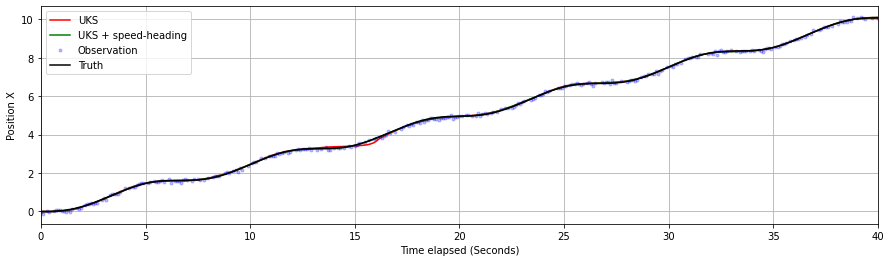

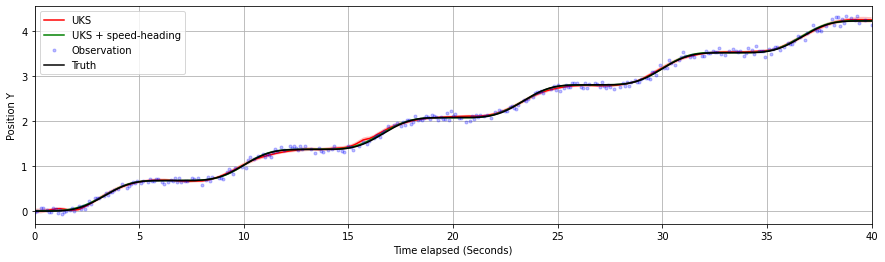

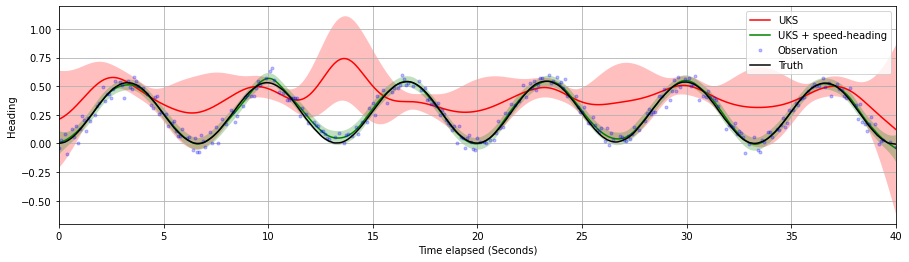

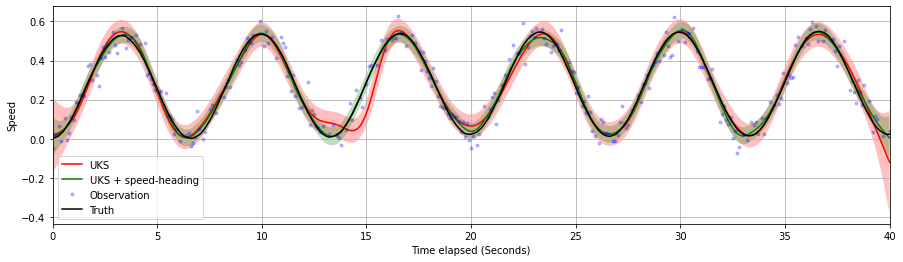

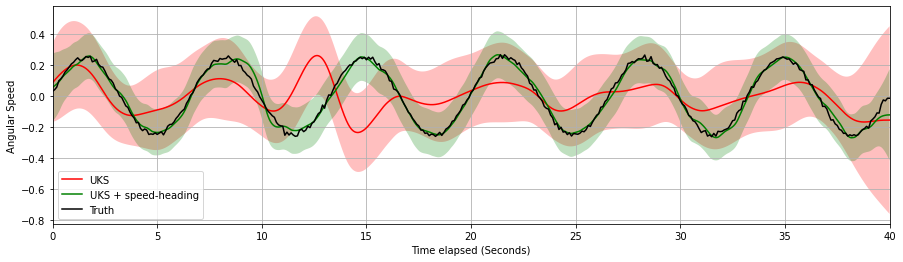

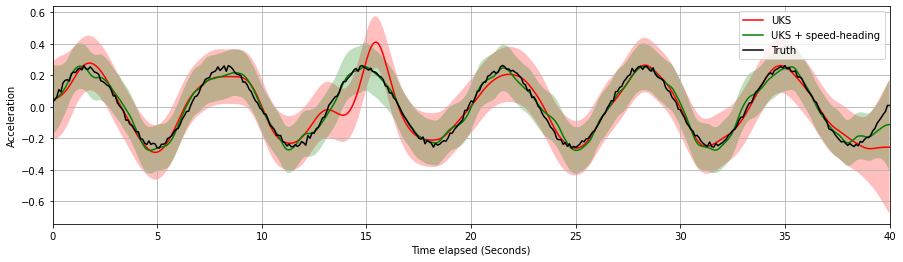

In [177]:
for i in range(mm.nx):
    fig, ax = plt.subplots(figsize=(15,4))
    #ekf.plot_state(ax, i, 'r', 'filter', linestyle='-', label='Filtered')
    ukf.plot_state(ax, i, 'r', 'smoother', linestyle='-', label='UKS')
    ukf2.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='UKS + speed-heading')
    #ekf2.plot_state(ax, i, 'c', 'smoother', linestyle='-', label='EKS')
    #ukf.plot_state(ax, i, 'g', 'filter', linestyle='-', label='UKF')
    for k, v in observed.items():
        if v == i:
            ax.plot(tobs, yobs[k,:], '.b', label='Observation', alpha=0.25)
    for k, v in truth.items():
        if v == i:
            ax.plot(ttrue, ytrue[k,:], '-k', label='Truth')
    #ekf.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='Smoother')
    #ax.set_xlim([20,40])
    ax.legend()
    ax.grid(True)

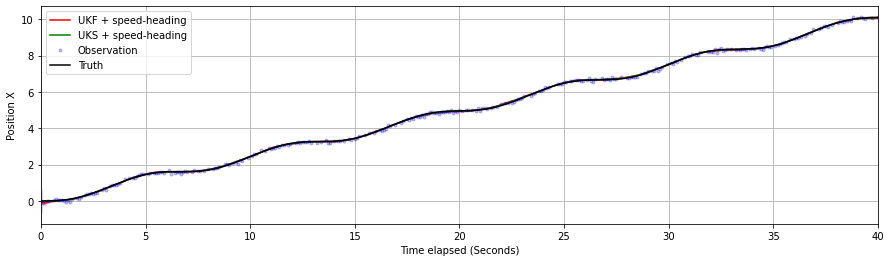

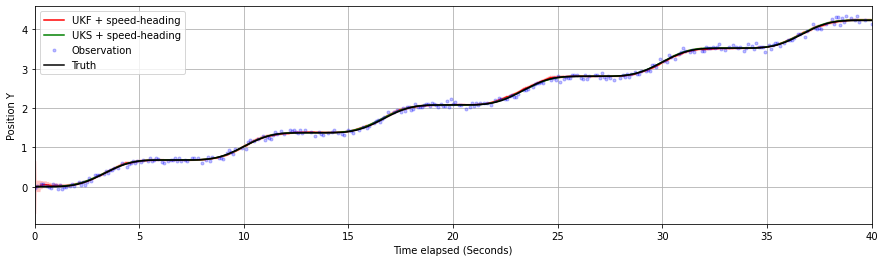

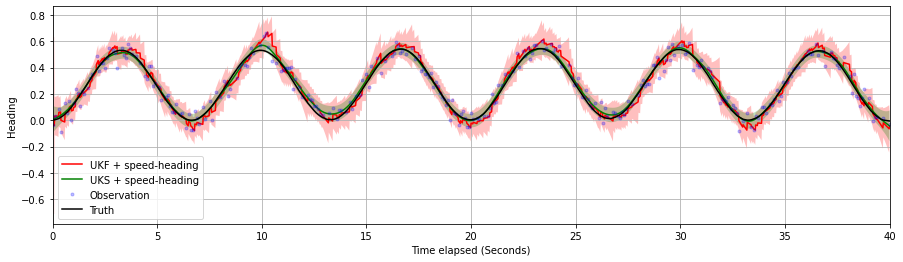

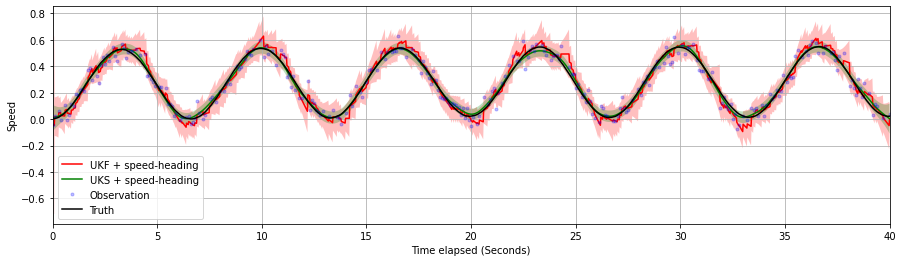

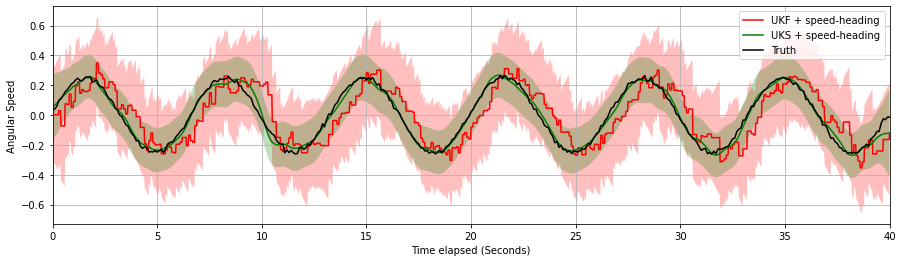

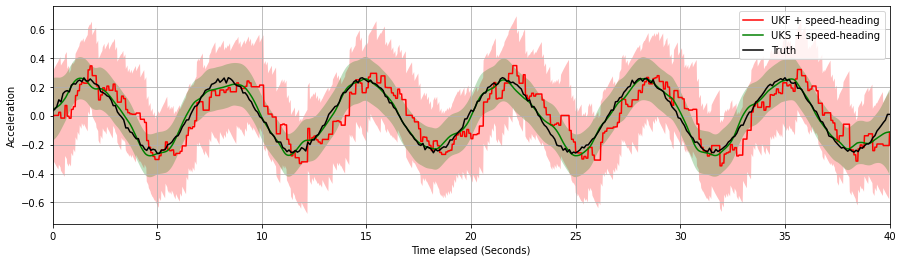

In [178]:
for i in range(mm.nx):
    fig, ax = plt.subplots(figsize=(15,4))
    #ekf.plot_state(ax, i, 'r', 'filter', linestyle='-', label='Filtered')
    ukf2.plot_state(ax, i, 'r', 'filter', linestyle='-', label='UKF + speed-heading')
    ukf2.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='UKS + speed-heading')
    #ekf2.plot_state(ax, i, 'c', 'smoother', linestyle='-', label='EKS')
    #ukf.plot_state(ax, i, 'g', 'filter', linestyle='-', label='UKF')
    for k, v in observed.items():
        if v == i:
            ax.plot(tobs, yobs[k,:], '.b', label='Observation', alpha=0.25)
    for k, v in truth.items():
        if v == i:
            ax.plot(ttrue, ytrue[k,:], '-k', label='Truth')
    #ekf.plot_state(ax, i, 'g', 'smoother', linestyle='-', label='Smoother')
    #ax.set_xlim([20,40])
    ax.legend()
    ax.grid(True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,3))
mname = 'nis'
ukf.plot_metric(ax, mname, color='b', ftype='filter', label='UKF')
ukf2.plot_metric(ax, mname, color='r', ftype='filter', label='UKF2')
ax.legend()

In [ ]:
np.diag([0,1])

In [ ]:
-10 % 360

In [194]:
data = np.arange(1,13)
data = data.reshape(3,4)
df = pd.DataFrame(data=data,columns=['a','b','c','d'])
df

,a,b,c,d
0,1,2,3,4
1,5,6,7,8
2,9,10,11,12


In [216]:
df_new_line = pd.DataFrame({'a':10,'c':20,'d':30}, index=[len(df)])
df = pd.concat([df,df_new_line], ignore_index=True)

In [217]:
df_new_line

,a,c,d
5,10,20,30


In [218]:
df

,a,b,c,d
0,1,2.0,3,4
1,5,6.0,7,8
2,9,10.0,11,12
3,10,NaN,20,30
4,10,NaN,20,30
5,10,NaN,20,30
